<a href="https://colab.research.google.com/github/pbenito1/TFM/blob/main/Preprocesado_ExtraccionCaracteristicas_AnalisisExploratorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install folderstats tldextract imbalanced-learn tranco

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Imports
import re
import os
from collections import Counter
import pandas as pd
from math import log
import folderstats
import tldextract
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import ensemble
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import imblearn
from tranco import Tranco


%matplotlib inline


In [3]:
# Estilos seaborn
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')


# Fuentes de datos

## Dominios malignos

### DGArchive
Analizaremos a continuación la fuente de datos para dominios malignos DGA proporcionada por [DGArchive](https://dgarchive.caad.fkie.fraunhofer.de/site/). 

Este archivo se ofrece por el FKEI del Instituto Fraunhofer previa solicitud  y sólo se puede emplear para fines no comerciales.

El conjunto de datos está compuesto por 93 archivos CSV que ocupan un total de 11 GB. 

Debido al gran tamaño del conjunto de datos, no es viable el análisis de su contenido utilizando la librería `pandas`, dado que excedería la memoria disponible. Por ese motivo, se realiza un análisis exploratorio inicial basado en el tamaño de los archivos. Para ello se hace uso de la librería `folderstats`.

In [4]:
dgarchive_path='/content/drive/MyDrive/TFM/data_raw/dgarchive'
df = folderstats.folderstats(dgarchive_path,  ignore_hidden=True)
# Eliminar la fila correspondiente al propio directorio
df = df.drop(df[df.name =='dgarchive'].index)
df[['name','size']]
df['size']=df['size']/(1024*1024)
df[['name','size']].sort_values(by=['size'], ascending=False).head(10)

,name,size
89,murofet_dga,2507.224755
88,gameover_dga,2271.215793
91,virut_dga,2070.866222
90,necurs_dga,1228.721256
35,qakbot_dga,426.769705
7,cryptolocker_dga,240.716837
10,dyre_dga,214.000111
5,conficker_dga,177.990954
33,qsnatch_dga,176.248784
20,monerominer_dga,175.751209


In [5]:
# Estadísticas del tamaño en megas
df[['size']].describe()

,size
count,92.000000
mean,119.385516
std,425.151380
min,0.000232
25%,0.033678
50%,1.825212
75%,35.087852
max,2507.224755


El tamaño medio de los archivos es de 119 MB. El fichero más grande ocupa  2.4GB y el más pequeño 23 KB. 

Lo más llamativo es el valor tan elevado de la desviación estándar (425 MB), lo que es indicativo de la heterogeneidad tan elevada  del tamaño del conjunto de datos.

Vamos a visualizar el tamaño de los archivos mediante un `barplot`

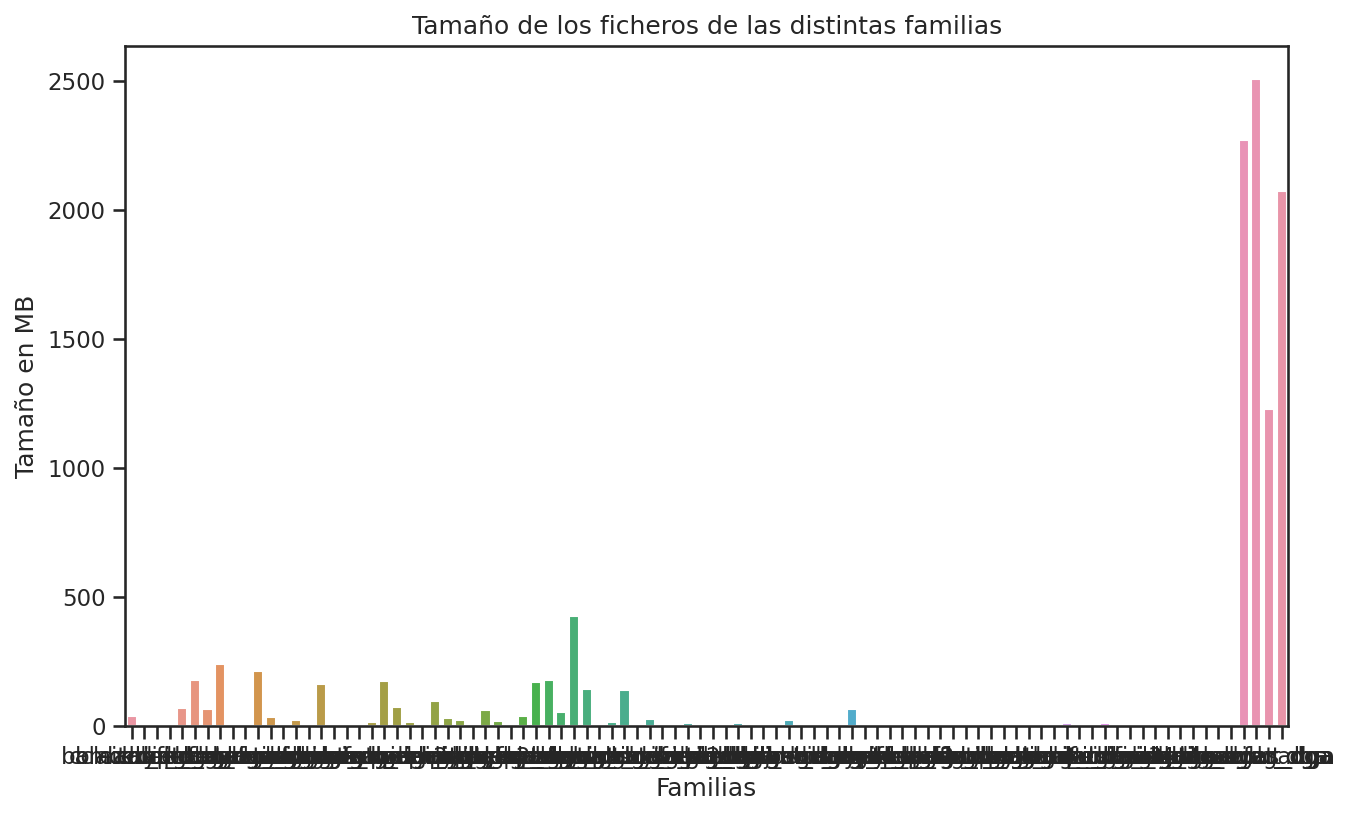

In [6]:
f, ax = plt.subplots(figsize=(10,6)) 
g=sns.barplot(data=df, x="name", y="size")
g.set(title='Tamaño de los ficheros de las distintas familias')
g.set(ylabel='Tamaño en MB')
_=g.set(xlabel='Familias')
#f.set_axis_labels(None)

El diagrama muestra claramente que hay cuatro familias de *malware* DGA que acaparan la mayoría de las muestras.

Estas familias son murofet, gameover, virut y necurs.

Con un diagrama de cajas se visualiza más adecuadamente la distribución del tamaño de los ficheros:

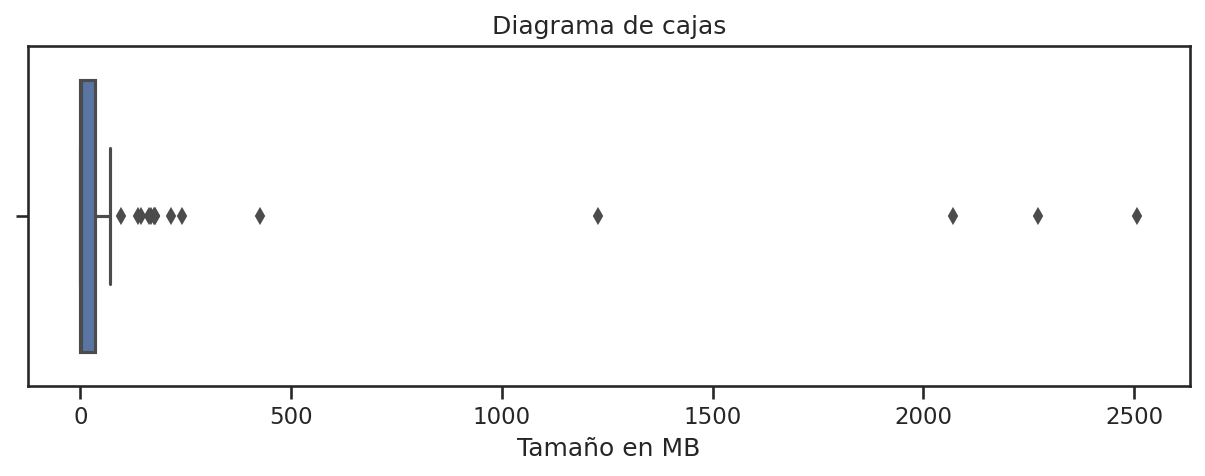

In [7]:
f, ax = plt.subplots(figsize=(10,3)) 
g1=sns.boxplot(data=df,x="size")
g1.set(title='Diagrama de cajas')
g1.set(xlabel='Tamaño en MB')
_=g1.plot()

El diagrama de cajas muestra un gran número de *outliers*, por encima del $Q3+1.5*IQR$ 
(Q3: tercer percentil, IQR: rango intercuartílco=Q3-Q1)

De la observación del tamaño de los archivos, se observa claramente que el *dataset* no se encuentra balanceado, existiendo **cuatro familias por encima de 1000 MB**.

Esta situación no es deseable, dado que los modelos entrenados tenderán a centrarse más en este tipo de datos, produciéndose una situación de *overfitting*. 


Una vez analizado el tamaño de los archivos, vamos a centrarnos en su contenido. 

Tras la conclusión del estudio anterior, aplicamos un *subsampling*,  limitando la carga a un **máximo de 10.000 elementos por familia** para disponer de un *dataset* más balanceado.

In [8]:
# Creamos un array con los archivos CSV a cargar con Pandas
res = []
for path in os.listdir(dgarchive_path):
    if os.path.isfile(os.path.join(dgarchive_path, path)):
        res.append(path)

In [9]:
MAX_ROWS_PER_FAMILY=10000
li = []
suffix = "_dga"
colnames=['domain', 'variant', 'start', 'end','family']
for index, row in df.iterrows():
    family=row['name'][:-len(suffix)]
    df_csv = pd.read_csv(row['path'], 
                         index_col=None, 
                         header=None, 
                         nrows=MAX_ROWS_PER_FAMILY,
                         names=colnames)
    # print("Tamaño familia",family,": ",df_csv.shape[0])
    # Obs: La familia no se puede obtener directamente del contenido del CSV 
    # dado que todos los CSV no tienen el mismo número de columnas.
    # Algunos CSV contienen dos columnas, mientras que otros tienen cinco.
    df_csv=df_csv.loc[:,['domain']]
    df_csv['domain']=df_csv['domain'].str.lower()
    df_csv.drop_duplicates(subset=['domain'])
    df_csv['family']=family
    li.append(df_csv)

balanced_df = pd.concat(li, axis=0, ignore_index=True)

# Eliminamos posibles dominios duplicados
balanced_df=balanced_df.drop_duplicates(subset=['domain'])


In [10]:
balanced_df.shape

(460545, 2)

El conjunto de datos limitado a 10.000 muestras por categoría está compuesto por un total de 564.756 dominios.

In [11]:
balanced_df.sample(10)

,domain,family
461659,wdc9y3s5b5j4h.info,ebury
103468,theandopinionsstatenure.ru,gozi
443906,pzfpdsn.com,pykspa2s
220749,5ab908f03c47.com,pandabanker
87584,qcb6731bea12a0f9ec69b94f647881b4f0.to,dyre
396026,myvcbbrksyro.dyndns.org,vidro
318069,iguvlmfheeanwjnf.com,sphinx
336463,wfccpgrwweweowzp.ru,sutra
247885,fanbudoklokr.kz,pushdo
370452,7b7502771836b51f2db5f926174c89d5.com,tinynuke


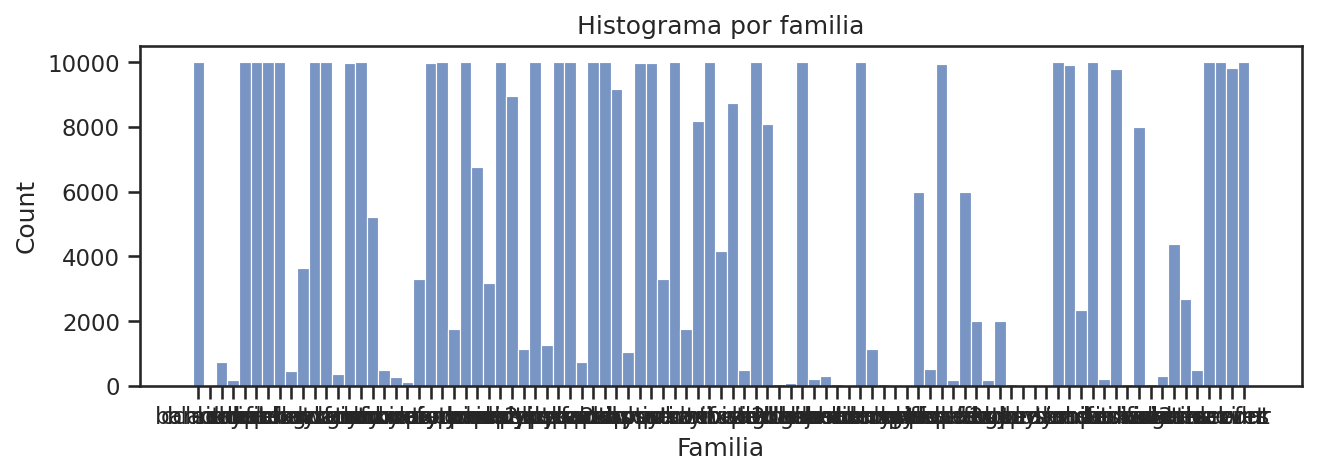

In [12]:
f, ax = plt.subplots(figsize=(10,3)) 
g1=sns.histplot(data=balanced_df,x="family")
g1.set(title='Histograma por familia')
g1.set(xlabel='Familia')
_=g1.plot()

Aunque visualmente se verifica que ahora el *dataset* se encuentra más balanceado, hay clases de las que hay muy pocas muestras. 

Para balancear aún más el *dataset*, realizaremos un *oversampling* en aquellas familias con pocas muestras. 

Aunque lo ideal sería generar nuevas muestras utilizando SMOTE (*Synthetic Minority Oversampling Technique*), esto es [dificil de aplicar](https://datascience.stackexchange.com/questions/27671/how-do-you-apply-smote-on-text-classification) en el caso de variables tipo cadena de caracteres, por lo que en este caso, simplemente repetimos las muestras existentes.

Para evitar *overfitting* hacia esas muestras repetidas, se decide que se aumentará el número de muestras hasta el mínimo de:
* un 300% del tamaño de muestras originales para la familia
* 10.000 muestras


In [13]:
lst_oversampling=[balanced_df]
for class_index, group in balanced_df.groupby('family'): 
  oversampling_size=min(MAX_ROWS_PER_FAMILY-len(group), len(group)*2)
  df_oversampling=group.sample(oversampling_size, replace=True)
  lst_oversampling.append(df_oversampling)
balanced_df = pd.concat(lst_oversampling, axis=0, ignore_index=True)

In [14]:
balanced_df.shape

(571268, 2)

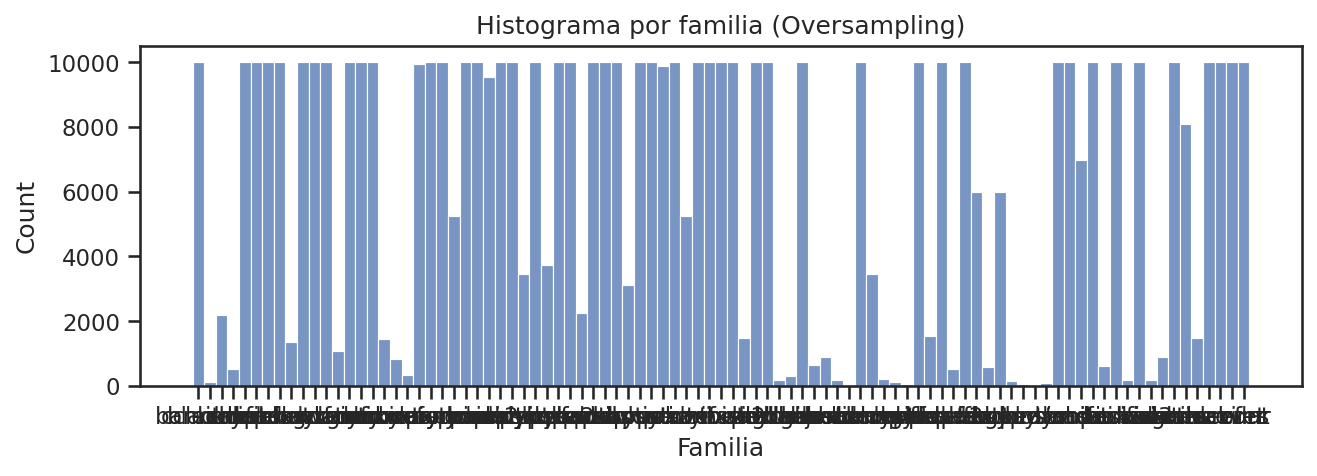

In [15]:
f, ax = plt.subplots(figsize=(10,3)) 
g1=sns.histplot(data=balanced_df,x="family")
g1.set(title='Histograma por familia (Oversampling)')
g1.set(xlabel='Familia')
_=g1.plot()


Finalmente añadimos una columna con la categoría que indica el caracter maligno de las muestras.

In [16]:
balanced_df['category']='malign'

## Dominios benignos

### Tranco List
Para los dominios benignos utilizamos como referencia la lista del proyecto europeo [Tranco](https://tranco-list.eu/).

Esta lista integra diversas fuentes de dominios: Alexa, Cisco Umbrella, Majestic, Quantcast y Farsight. El ranking de los dominios es calculado a partir del ranking medio de los diversos proveedores durante los últimos 30 días.

Para obtener un dataset balanceado entre muestras benignas y malignas, cargamos el mismo número de elementos que la la lista de dominios DGA balanceada.

In [17]:
balanced_df.shape

(571268, 3)

In [18]:
t = Tranco(cache=True, cache_dir='.tranco')
tranco_list=t.list().list

In [19]:
tranco_df=pd.DataFrame({'domain':tranco_list},index=list(range(0, len(tranco_list))))

Para que el *dataset* sea más representativo, calculamos el SLD de cada dominio y eliminamos los duplicados (p.ej se mantiene google.com, pero se eliminan google.es, google.de, ...)

In [20]:
tranco_df['sld'] = tranco_df['domain'].apply(lambda d:tldextract.extract(d)[-2])
tranco_df=tranco_df.drop_duplicates(subset='sld', keep='first')

In [21]:
tranco_df.shape

(867273, 2)

Eliminamos los elementos de la lista Tranco que se encuentren en la lista DGA

In [22]:
tranco_dga_df=tranco_df[tranco_df['domain'].isin(balanced_df['domain'])]
tranco_dga_df

,domain,sld
9094,danawa.com,danawa
175226,1111111.com,1111111
251820,gvaq70s7he.ru,gvaq70s7he
329053,76236osm1.ru,76236osm1
368927,covyn.net,covyn
456935,zbum2hkm.ru,zbum2hkm
525742,restaurantconnect.com,restaurantconnect
628375,banked.com,banked
640564,xqzdkh56y.ru,xqzdkh56y
856331,doctorstretch.com,doctorstretch


In [23]:
tranco_df.drop(tranco_dga_df.index,inplace=True)

In [24]:
tranco_df.shape

(867261, 2)

Eliminamos los dominios `unicode`, representados utilizando `punycode`. Estos dominios comienzan por `'xn--'`


In [25]:
tranco_df=tranco_df[~tranco_df['domain'].str.startswith('xn--')]
tranco_df.shape

(865427, 2)

Pasamos a minúsculas el dominio, eliminamos la columna SLD y añadimos la columna `category=benign`

In [26]:
tranco_df['category']='benign'
tranco_df=tranco_df.drop(['sld'], axis=1)
tranco_df['domain']=tranco_df['domain'].str.lower()
# Eliminamos duplicados
tranco_df.drop_duplicates()
tranco_df.head()

<ipython-input-26-83be2a72bc1b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tranco_df['category']='benign'


,domain,category
0,google.com,benign
1,a-msedge.net,benign
2,youtube.com,benign
3,facebook.com,benign
4,microsoft.com,benign


Fusionamos la lista Tranco (top N) y la lista balanceada DGA. Ambas listas tienen el mismo número de elementos.

In [27]:
full_df = pd.concat([balanced_df,tranco_df[0:balanced_df.shape[0]]], axis=0, ignore_index=True)

In [28]:
full_df.sample(20)

,domain,family,category
141525,cxaebiahmr.net,nymaim,malign
542365,uxcdqpa.org,tempedreve,malign
385509,omb47wxfbo25zqthz7.net,rovnix,malign
438693,kstsvjmlfqbslogr.org,murofet,malign
325065,jmbedcrbpg.com,dnschanger,malign
517096,jmzsxunylc.com,pushdotid,malign
117344,iqgzk27pyn40f22i55mzosmvdyiwnrjvp32mq.com,murofetweekly,malign
992321,wdstelecom.com.br,NaN,benign
588408,colorhunt.co,NaN,benign
742402,azinogo.com,NaN,benign


In [29]:
full_df.shape

(1142536, 3)

# Extracción de características
Obtenemos los siguientes atributos adicionales a partir de la división del dominio en sus componentes y sus característias léxicas:
- TLD
- SLD
- Número de subdominios
- Número de dígitos en el SLD
- Longitud del SLD
- Número de guiones en el SLD
- Índice de entropía de Shannon del SLD (aleatoriedad en los caracteres)
- Ratio Vocal/Consonante


In [30]:
# Extracción de características
def shannon(string):
  '''
    Calcula el índice de entropia de shannon
  '''
  # Ref: reddit.com/r/learnpython/comments/g1sdkh/python_programming_challenge_calculating_shannon/ 
  counts = Counter(string)
  frequencies = ((i / len(string)) for i in counts.values())
  return - sum(f * log(f, 2) for f in frequencies)

def num_digits(domain):
    p = re.compile("\d")
    digits = p.findall(domain)
    return len(digits)


def ratio_vc(domain):
  '''
    Calcula el ratio entre vocales y consonantes
  '''
  # Ref: https://pencilprogrammer.com/python-programs/count-vowels-and-consonants/ 
  v = 0
  c = 0
  for x in domain:
    if x in ['a', 'e', 'i', 'o', 'u']:
        v += 1
    elif x != '-':
        c += 1
  try:
    ratio = v / c
  except: 
    ratio = 0  
  return ratio

#balanced_df['domain_upper'] = balanced_df['domain'].apply(lambda x: x.upper())
full_df['tld'] = full_df['domain'].apply(lambda d:tldextract.extract(d)[-1])
full_df['sld'] = full_df['domain'].apply(lambda d:tldextract.extract(d)[-2])
full_df['subdomains_number'] = full_df['domain'].apply(lambda d:len(d.split('.')))
full_df['digits'] = full_df['sld'].apply(num_digits)
full_df['length'] = full_df['sld'].apply(lambda x: len(x))
full_df['num_dashes'] = full_df['sld'].apply(lambda x: len(re.compile("\-").findall(x)))
full_df['entropy'] = full_df['sld'].apply(lambda x:shannon(x))
full_df['ratio_vc'] = full_df['sld'].apply(lambda x:ratio_vc(x))


In [31]:
full_df.shape

(1142536, 11)

In [32]:
full_df.sample(10)

,domain,family,category,tld,sld,subdomains_number,digits,length,num_dashes,entropy,ratio_vc
815958,queenwiz.com,NaN,benign,com,queenwiz,2,0,8,0,2.750000,1.000000
69714,pajkppjicqlfrbkn.eu,emotet,malign,eu,pajkppjicqlfrbkn,2,0,16,0,3.452820,0.142857
638285,dagotel.ru,NaN,benign,ru,dagotel,2,0,7,0,2.807355,0.750000
46329,yfttbtfcdcnj.co.uk,cryptolocker,malign,co.uk,yfttbtfcdcnj,3,0,12,0,2.855389,0.000000
524015,ywwwegoyiugyamaa.org,ramdo,malign,org,ywwwegoyiugyamaa,2,0,16,0,2.983459,0.777778
365621,voytrvhpfxcwcir.com,ramnit,malign,com,voytrvhpfxcwcir,2,0,15,0,3.506891,0.153846
40289,581jobadqp5bif587rq.ddns.net,corebot,malign,net,ddns,3,0,4,0,1.500000,0.000000
679256,youblog.jp,NaN,benign,jp,youblog,2,0,7,0,2.521641,0.750000
776273,ropinirolec.com,NaN,benign,com,ropinirolec,2,0,11,0,2.913977,0.833333
579476,advanced-web-analytics.com,NaN,benign,com,advanced-web-analytics,2,0,22,2,3.641250,0.538462


# Cálculo de n-gramas

A continuación obtendremos características basadas en ngrams.

Para ello determinaremos los ngrams de longitud 3, 4, 5 y 6 presentes en los SLD de los dominios benignos.

A continuación contaremos cuantos de estos ngrams están presentes en todos los SLD que conforman el dataset. Ese número lo almacenaremos en los atributos `3gram`, `4gram`, `5gram` y `6gram` respectivamente.

In [33]:
benign_cv_3gram=feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3, 3))#,max_features=500)
benign_cv_4gram=feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(4, 4))#,max_features=500)
benign_cv_5gram=feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(5, 5))#,max_features=500)
benign_cv_6gram=feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(6, 6))#,max_features=500)

benign_cv_3gram.fit(full_df[full_df.category=='benign'].sld.values.astype('U'))
benign_cv_4gram.fit(full_df[full_df.category=='benign'].sld.values.astype('U'))
benign_cv_5gram.fit(full_df[full_df.category=='benign'].sld.values.astype('U'))
benign_cv_6gram.fit(full_df[full_df.category=='benign'].sld.values.astype('U'))

CountVectorizer(analyzer='char', ngram_range=(6, 6))

In [34]:
sum_3gram=benign_cv_3gram.transform(full_df.sld.values.astype('U')).sum(axis=1)
sum_4gram=benign_cv_4gram.transform(full_df.sld.values.astype('U')).sum(axis=1)
sum_5gram=benign_cv_5gram.transform(full_df.sld.values.astype('U')).sum(axis=1)
sum_6gram=benign_cv_6gram.transform(full_df.sld.values.astype('U')).sum(axis=1)

# Nuevas features: 3gram, 4gram, 5gram y 6gram
full_df['3gram']=np.squeeze(np.asarray(sum_3gram))
full_df['4gram']=np.squeeze(np.asarray(sum_4gram))
full_df['5gram']=np.squeeze(np.asarray(sum_5gram))
full_df['6gram']=np.squeeze(np.asarray(sum_6gram))

# Análisis exploratorio
## Distribución por TLD
Analizamos en primer lugar los dominios de nivel superior. Al utilizar la librería `tldextract`, además de los TLD clásicos (.COM, .NET, ...), se consideran TLD dominos del tipo ".CO.UK".


In [35]:
len(full_df[full_df['category']=='benign']['tld'].value_counts())

1381

In [36]:
print("Total dominios TLD distintos: ",len(full_df['tld'].value_counts()))
print("Total dominios TLD benignos: ",len(full_df[full_df['category']=='benign']['tld'].value_counts()))
print("Total dominios TLD malignos: ",len(full_df[full_df['category']=='malign']['tld'].value_counts()))

Total dominios TLD distintos:  1385
Total dominios TLD benignos:  1381
Total dominios TLD malignos:  120


En el caso de las muestras malignas, se utilizan 120 TLD distintos. Los dominios benignos tienen hasta 1941 TLD distintos

In [37]:
top=15
top_tld=full_df["tld"].value_counts()[0:top].index
top_tld_df=full_df[full_df["tld"].isin(top_tld)]

Text(0, 0.5, 'Número de dominios')

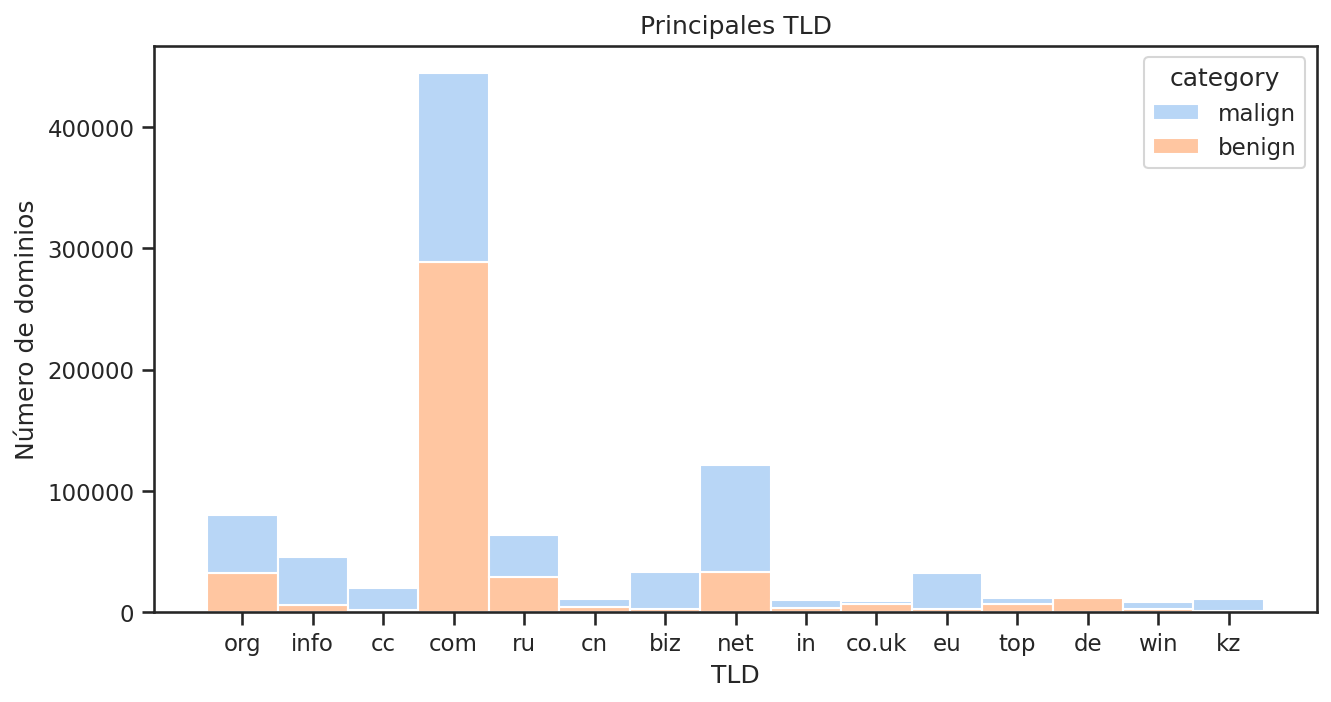

In [39]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(1,1,1)
sns.histplot(data=top_tld_df, ax=ax, multiple="stack",
             x="tld",
             palette="pastel", hue="category",
             element="bars", legend=True)
ax.set_title("Principales TLD")
ax.set_xlabel("TLD")
ax.set_ylabel("Número de dominios")

El histograma anterior muestra los TLD que cuentan con más de 1000 muestras.
El TLD mayoritario es el .COM, seguido del .NET.

Se observa que hay TLD que son de uso prácticamente exclusivo por parte de DGA, como .INFO, .CC, .BIZ o .EU.

## Longitud del dominio
Analizaremos a continuación la longitud de los dominios

Text(0, 0.5, 'Número de dominios')

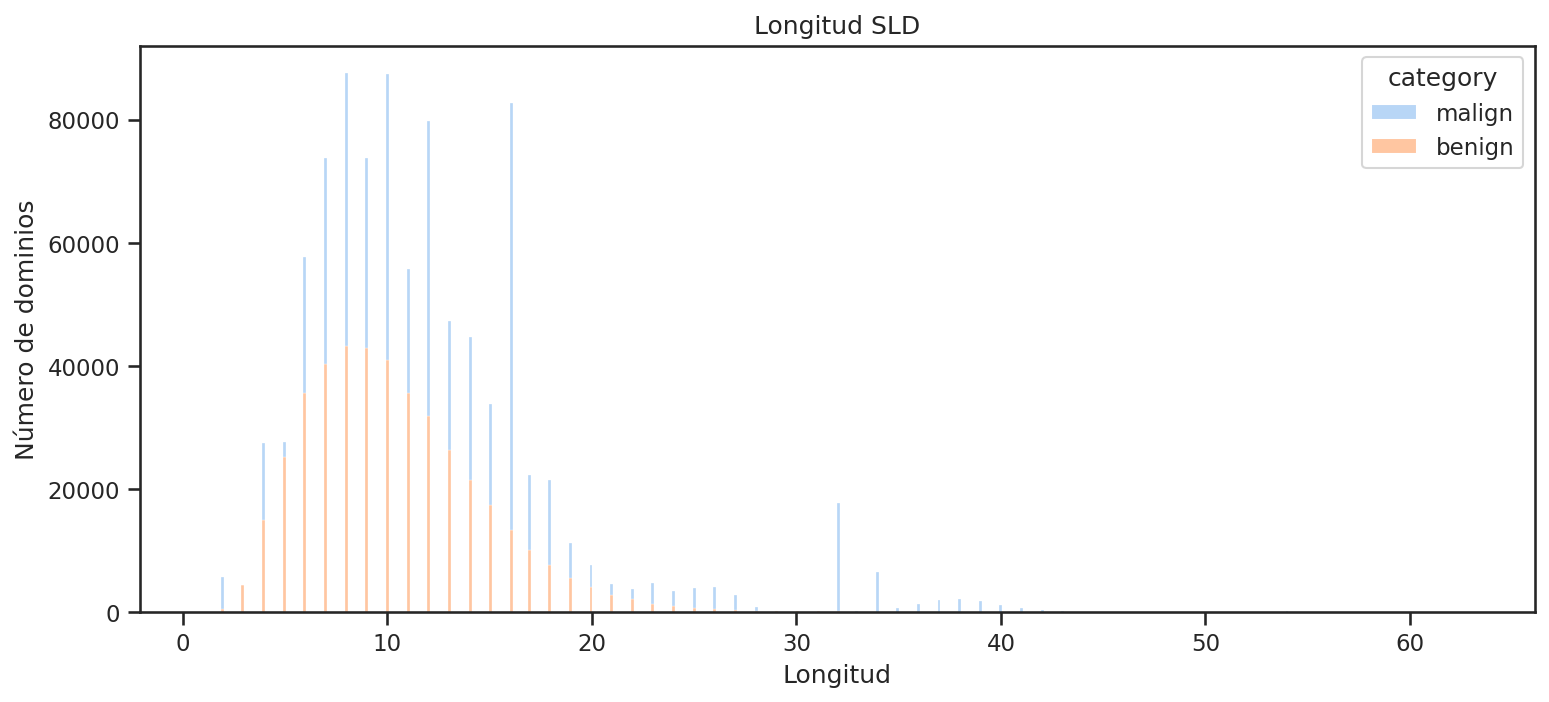

In [40]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,1,1)
sns.histplot(data=top_tld_df, ax=ax, stat="count", multiple="stack",
             x="length", kde=False,
             palette="pastel", hue="category",
             element="bars", legend=True)
ax.set_title("Longitud SLD")
ax.set_xlabel("Longitud")
ax.set_ylabel("Número de dominios")

Se puede observar que, aunque siguen una distribución similar, por un lado, a partir de los 25 caracteres únicamente hay muestras malignas y, por otro lado, hay determinadas longitudes (12 y 16 caracteres, probablemente correspondientes a familias de DGA concretas) para las que hay un pico evidente en el caso de los dominios malignos.

## Dígitos

Text(0, 0.5, 'Número de dominios')

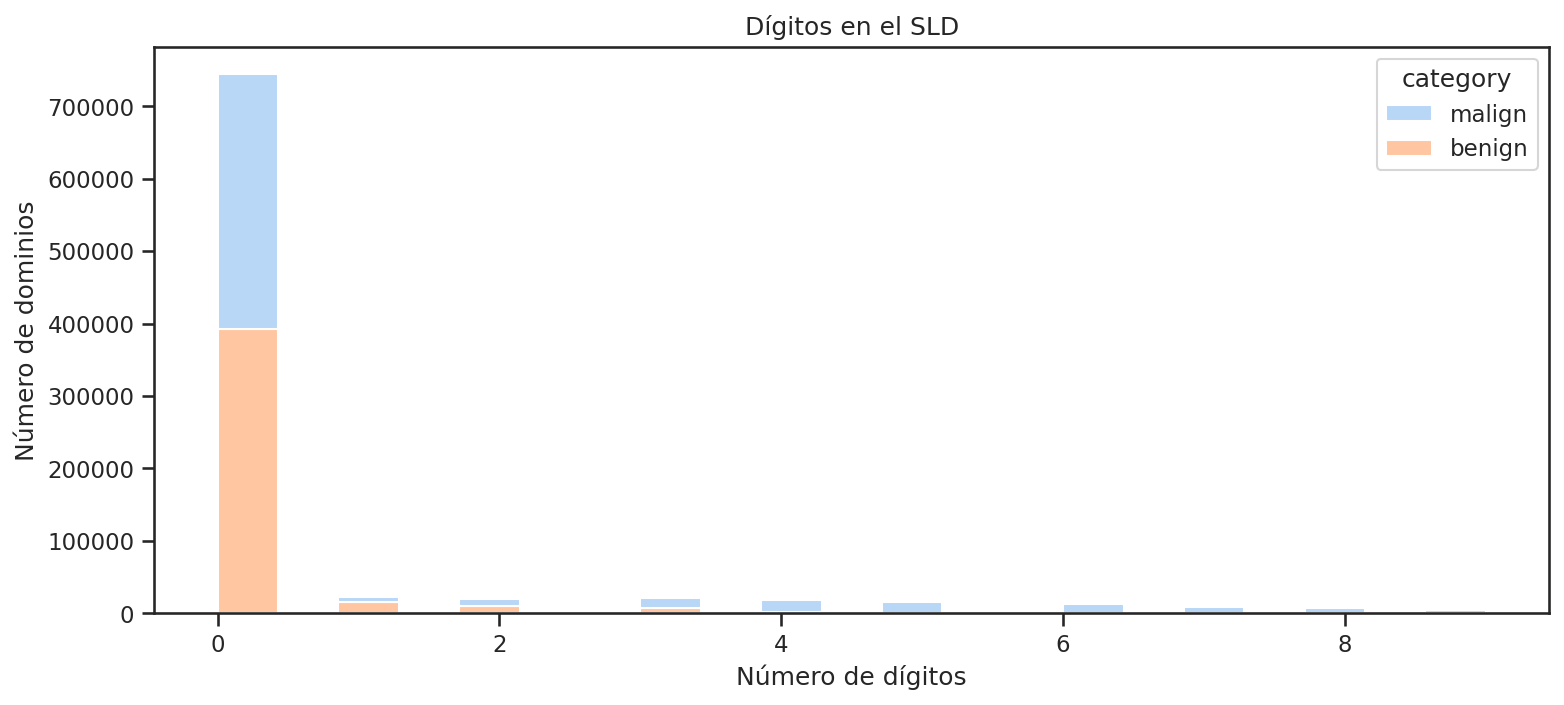

In [41]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,1,1)
MAX_DIGITS_TO_PLOT=10
sns.histplot(data=top_tld_df[top_tld_df['digits']<MAX_DIGITS_TO_PLOT], ax=ax, multiple="stack",
             x="digits",
             palette="pastel", hue="category",
             element="bars", legend=True)
ax.set_title("Dígitos en el SLD")
ax.set_xlabel("Número de dígitos")
ax.set_ylabel("Número de dominios")

La gran mayoría de dominios del conjunto de datos no tiene ningún dígito y hay una distribución equitativa entre dominios benignos y malignos. 

Se observa que a partir de 4 dígitos, únicamente hay muestras malignas.

## Guiones
Analizamos la distribución de los dominios en función del número de guiones contenidos en el SLD.

[]

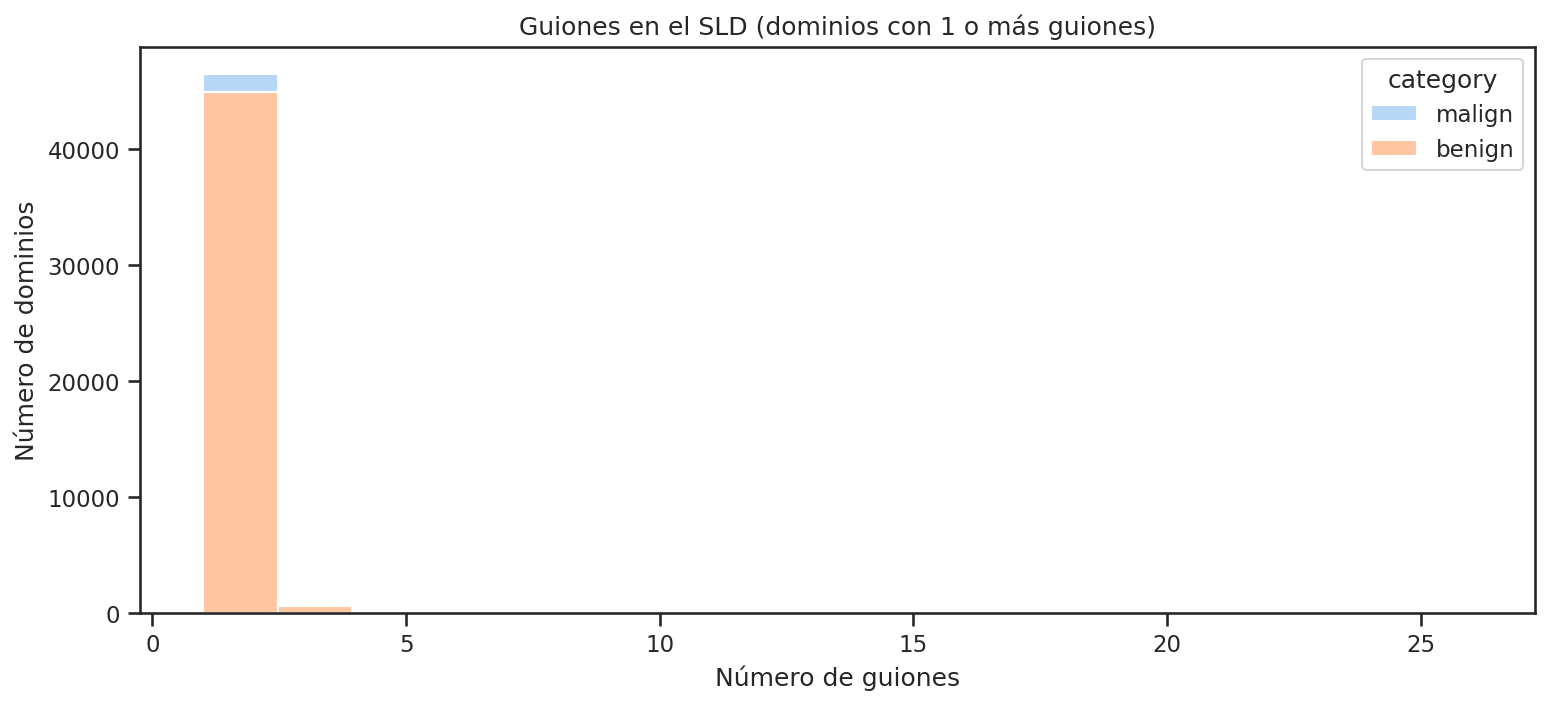

In [42]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,1,1)
sns.histplot(data=top_tld_df[top_tld_df['num_dashes']>0], ax=ax, multiple="stack",
             x="num_dashes", 
             palette="pastel", hue="category",
             element="bars", legend=True)
ax.set_title("Guiones en el SLD (dominios con 1 o más guiones)")
ax.set_xlabel("Número de guiones")
ax.set_ylabel("Número de dominios")
ax.plot()

La gran mayoría de dominios no tiene ningún guión, con lo que el histograma no es representativo. Calculamos a continuación el número de elementos por número de guiones y categoría:

In [43]:
full_df[['num_dashes','category']].value_counts(ascending=False)

num_dashes  category
0           malign      565981
            benign      511171
1           benign       53144
2           benign        5919
1           malign        5110
3           benign         860
26          malign         177
4           benign         139
5           benign          19
6           benign           7
25          benign           5
7           benign           1
9           benign           1
10          benign           1
12          benign           1
dtype: int64

La distribución de dominios sin guion es similar entre los dominios malignos y benignos, sin embargo la mayoría de los dominios con más de un guion son benignos. 

Llama la atención el caso de dominios malignos con 26 guiones, sin duda correspondiente a una familia de DGA específica.

## Ratio vocal-consonante

Text(0, 0.5, 'Dominios')

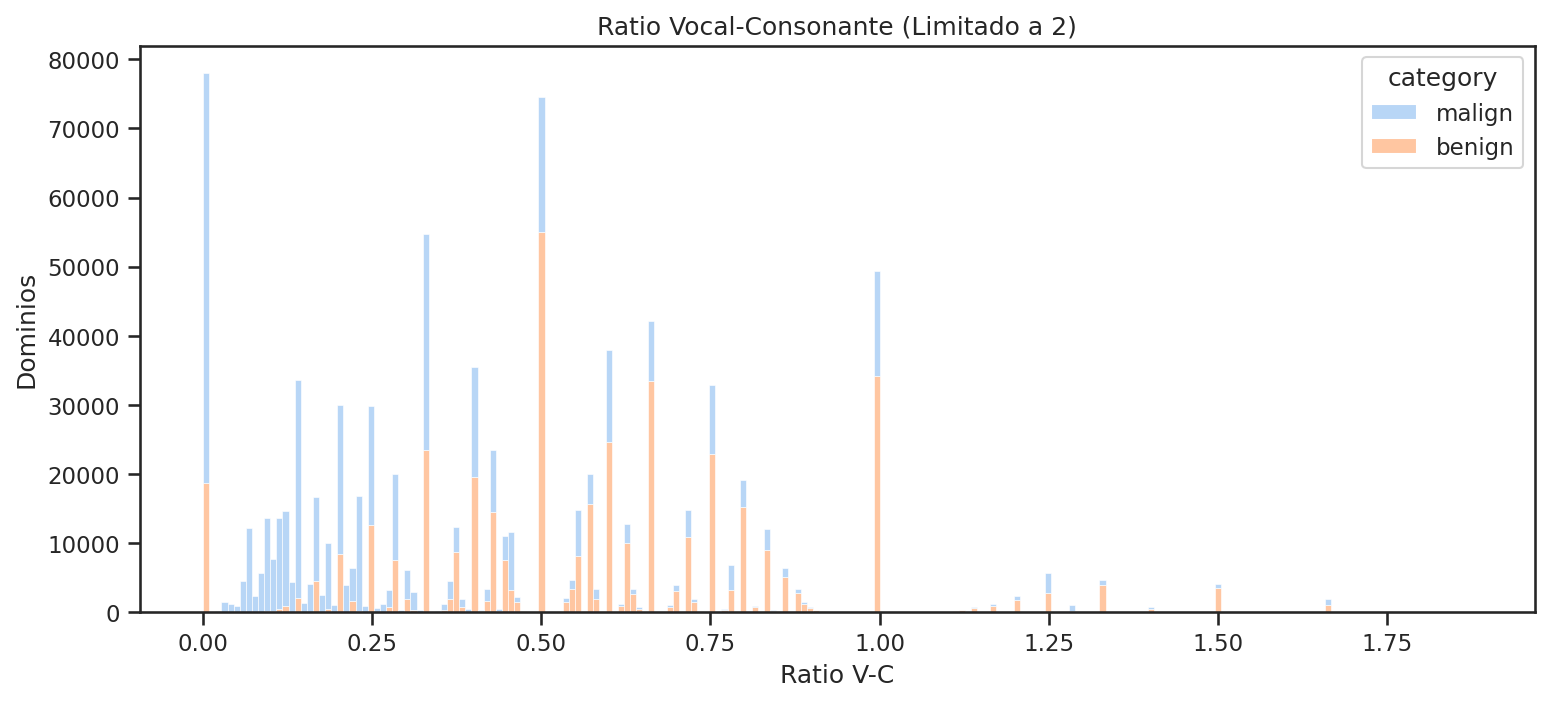

In [44]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,1,1)
MAX_RATIO_TO_PLOT=2
sns.histplot(data=top_tld_df[top_tld_df['ratio_vc']<MAX_RATIO_TO_PLOT], ax=ax, stat="count", multiple="stack",
             x="ratio_vc", kde=False,
             palette="pastel", hue="category",
             element="bars", legend=True)
ax.set_title("Ratio Vocal-Consonante (Limitado a 2)")
ax.set_xlabel("Ratio V-C")
ax.set_ylabel("Dominios")

Este gráfico se ha limitado a un máximo de ratio 2, dado que existen dominios con ratios superiores a 10 que hacían la gráfica ilegible.

En la gráfica se puede observar que hay un gran número de dominios formados únicamente por vocales (ratio 0), otro gran número de dominios tienen un ratio de 0.5, tanto para dominios legítimos como para DGA, lo que indica que tiene el mismo número de consontantes y vocales.

Respecto a la distribución benigno-maligno, se observa que los dominios malignos son mayoritarios en el rango 0-0.25, mientras que los benignos lo son en el rango 0.5-1.

## N-gramas

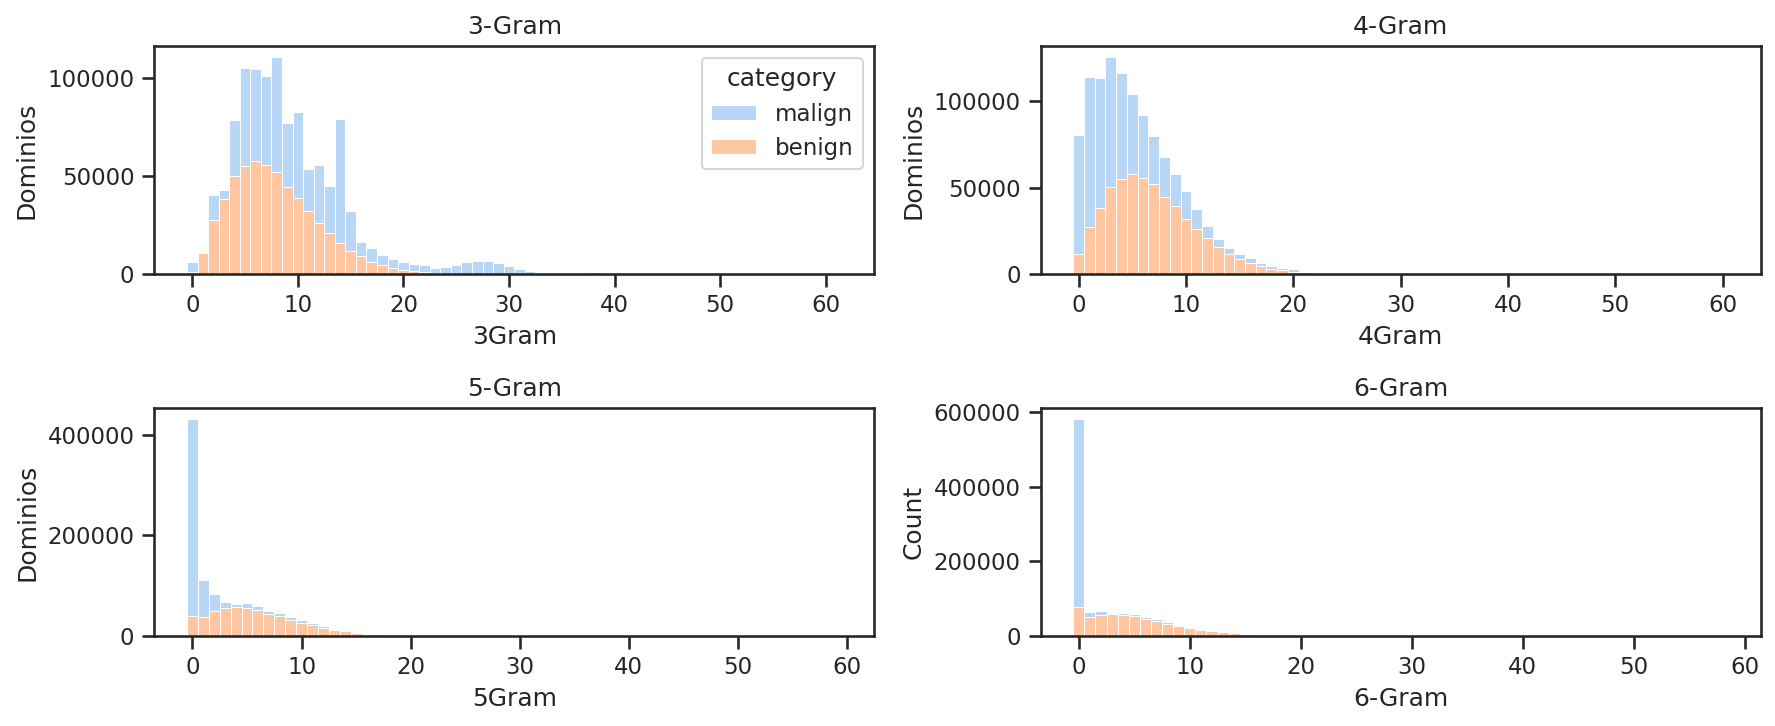

In [45]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(2,2,1)
sns.histplot(data=full_df, ax=ax, stat="count", multiple="stack",
             x="3gram", kde=False,
             palette="pastel", hue="category",
             element="bars", legend=True,discrete=True)
ax.set_title("3-Gram")
ax.set_xlabel("3Gram")
ax.set_ylabel("Dominios")

ax = f.add_subplot(2,2,2)
sns.histplot(data=full_df, ax=ax, stat="count", multiple="stack",
             x="4gram", kde=False,
             palette="pastel", hue="category",
             element="bars", legend=False,discrete=True)
ax.set_title("4-Gram")
ax.set_xlabel("4Gram")
ax.set_ylabel("Dominios")

ax = f.add_subplot(2,2,3)
sns.histplot(data=full_df, ax=ax, stat="count", multiple="stack",
             x="5gram", kde=False,
             palette="pastel", hue="category",
             element="bars", legend=False,discrete=True)
ax.set_title("5-Gram")
ax.set_xlabel("5Gram")
ax.set_ylabel("Dominios")

ax = f.add_subplot(2,2,4)
sns.histplot(data=full_df, ax=ax, stat="count", multiple="stack",
             x="6gram", kde=False,
             palette="pastel", hue="category",
             element="bars", legend=False,discrete=True)
ax.set_title("6-Gram")
ax.set_xlabel("6-Gram")
plt.tight_layout()
plt.show()

En los histogramas se puede observar que mientras en la distribución de 3-gramas entre dominios benignos y malignos es similar, en el caso de 4-gramas se observa que hay un mayor número de n-gramas entre los benignos. En el caso de 5-gramas, y especialmente en 6-gramas se observa que hay una prevalencia prácticamente total entre los benignos.

# Estadísticos de las distintas características

Seleccionamos los atributos numéricos y aplicamos un escalado basado en la desviación estandar a sus valores para poder comparar los datos.

In [47]:
var_df=full_df.drop(['category','domain','family','tld','sld'],axis=1)
var_df_std_scaler = StandardScaler().fit_transform(var_df)
var_df_std = pd.DataFrame(var_df_std_scaler, index=var_df.index, columns=var_df.columns)

In [64]:
full_df.describe()

,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
count,1.142536e+06,1.142536e+06,1.142536e+06,1.142536e+06,1.142536e+06,1.142536e+06,1.142536e+06,1.142536e+06,1.142536e+06,1.142536e+06
mean,2.061784e+00,1.383479e+00,1.191118e+01,6.838297e-02,2.916993e+00,4.563648e-01,9.468478e+00,5.560056e+00,3.597485e+00,2.792636e+00
std,2.419444e-01,4.046295e+00,6.476296e+00,4.291591e-01,5.721175e-01,3.545199e-01,5.787931e+00,4.259868e+00,4.348061e+00,3.946110e+00
min,2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,8.000000e+00,0.000000e+00,2.584963e+00,2.000000e-01,6.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,2.947703e+00,4.166667e-01,8.000000e+00,5.000000e+00,2.000000e+00,0.000000e+00
75%,2.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,3.281036e+00,6.666667e-01,1.200000e+01,8.000000e+00,6.000000e+00,5.000000e+00
max,4.000000e+00,4.700000e+01,6.300000e+01,2.600000e+01,4.879506e+00,1.966667e+01,6.100000e+01,6.000000e+01,5.900000e+01,5.800000e+01


In [49]:
var_df_std[full_df['category']=='benign'].describe()

,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
count,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000
mean,0.070079,-0.295553,-0.305573,0.119728,-0.240487,0.398874,-0.265417,0.322523,0.542047,0.565194
std,1.121891,0.190034,0.661127,0.887195,0.887671,0.950428,0.739735,1.004394,0.976937,1.053742
min,-0.255363,-0.341913,-1.684787,-0.159342,-5.098594,-1.287276,-1.635901,-1.305219,-0.827377,-0.707694
25%,-0.255363,-0.341913,-0.758332,-0.159342,-0.723165,-0.158989,-0.772034,-0.366222,-0.137414,-0.200865
50%,-0.255363,-0.341913,-0.449513,-0.159342,-0.125223,0.324562,-0.426487,0.103277,0.322561,0.305963
75%,-0.255363,-0.341913,0.013715,-0.159342,0.368966,0.828262,0.091833,0.807524,1.012524,1.066206
max,8.011002,11.273656,7.888589,58.094143,2.776853,54.186832,8.903276,12.779732,12.741895,13.990333


In [50]:
var_df_std[full_df['category']=='malign'].describe()

,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
count,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000,571268.000000
mean,-0.070079,0.295553,0.305573,-0.119728,0.240487,-0.398874,0.265417,-0.322523,-0.542047,-0.565194
std,0.855303,1.337605,1.173100,1.088218,1.047080,0.882320,1.145383,0.884959,0.676732,0.500742
min,-0.255363,-0.341913,-1.530378,-0.159342,-5.098594,-1.287276,-1.635901,-1.305219,-0.827377,-0.707694
25%,-0.255363,-0.341913,-0.449513,-0.159342,-0.291887,-0.973863,-0.599261,-1.070469,-0.827377,-0.707694
50%,-0.255363,-0.341913,0.013715,-0.159342,0.312527,-0.636341,0.091833,-0.600971,-0.827377,-0.707694
75%,-0.255363,0.399507,0.631352,-0.159342,0.940068,-0.033624,0.782926,0.103277,-0.597389,-0.707694
max,8.011002,7.072280,6.498906,60.424283,3.430264,24.099180,7.348316,5.502508,4.692327,4.867420


Calculamos el valor absoluto de la diferencia entre las medias de los distintos atributos:

In [51]:
# Valor absoluto de la diferencia entre las medias, una vez estandarizados los valores
(var_df_std[full_df['category']=='benign'].describe().loc['mean']-var_df_std[full_df['category']=='malign'].describe().loc['mean']).abs().sort_values(ascending=False)

6gram                1.130387
5gram                1.084094
ratio_vc             0.797748
4gram                0.645045
length               0.611145
digits               0.591105
3gram                0.530834
entropy              0.480973
num_dashes           0.239455
subdomains_number    0.140158
Name: mean, dtype: float64

Las estadísticas ratifican los estudios visuales realizados en los apartados anteriores. Las mayores diferencias en los valores medios se observan en el número 6gram, 5gram, ratio_vc, 4gram y length.

Las variables para las que hay menos diferencia son el número de subdominios, número de guiones y entropía.

## Correlación de variables
Vamos a analizar a continuación la correlación entre las características calculadas.

In [52]:
corr_benign=full_df[full_df['category']=='benign'].corr()
corr_benign

,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
subdomains_number,1.000000,-0.044575,-0.084122,-0.031270,-0.101721,0.020692,-0.084127,-0.084059,-0.082268,-0.077212
digits,-0.044575,1.000000,-0.010895,0.078880,-0.015721,-0.218573,-0.010894,-0.010799,-0.010452,-0.009244
length,-0.084122,-0.010895,1.000000,0.232350,0.805090,0.088482,0.999998,0.999949,0.999336,0.996765
num_dashes,-0.031270,0.078880,0.232350,1.000000,0.203916,-0.001113,0.232352,0.232387,0.232730,0.233156
entropy,-0.101721,-0.015721,0.805090,0.203916,1.000000,0.027734,0.805033,0.804142,0.797456,0.780880
ratio_vc,0.020692,-0.218573,0.088482,-0.001113,0.027734,1.000000,0.088459,0.088128,0.085800,0.081080
3gram,-0.084127,-0.010894,0.999998,0.232352,0.805033,0.088459,1.000000,0.999954,0.999345,0.996776
4gram,-0.084059,-0.010799,0.999949,0.232387,0.804142,0.088128,0.999954,1.000000,0.999477,0.996984
5gram,-0.082268,-0.010452,0.999336,0.232730,0.797456,0.085800,0.999345,0.999477,1.000000,0.998418
6gram,-0.077212,-0.009244,0.996765,0.233156,0.780880,0.081080,0.996776,0.996984,0.998418,1.000000


In [53]:
corr_malign=full_df[full_df['category']=='malign'].corr()
corr_malign

,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
subdomains_number,1.000000,-0.099720,-0.250461,-0.007886,-0.489359,-0.095349,-0.259644,-0.144322,-0.053723,-0.037007
digits,-0.099720,1.000000,0.724870,0.071439,0.374225,-0.260808,0.639267,-0.077258,-0.170666,-0.133842
length,-0.250461,0.724870,1.000000,0.093359,0.743046,-0.133919,0.977342,0.363512,0.105515,0.088896
num_dashes,-0.007886,0.071439,0.093359,1.000000,-0.046110,0.000175,0.111194,0.023842,0.048099,0.053733
entropy,-0.489359,0.374225,0.743046,-0.046110,1.000000,-0.110314,0.725954,0.323714,0.110553,0.085281
ratio_vc,-0.095349,-0.260808,-0.133919,0.000175,-0.110314,1.000000,-0.087716,0.340838,0.330357,0.261938
3gram,-0.259644,0.639267,0.977342,0.111194,0.725954,-0.087716,1.000000,0.463226,0.169424,0.139390
4gram,-0.144322,-0.077258,0.363512,0.023842,0.323714,0.340838,0.463226,1.000000,0.779646,0.661499
5gram,-0.053723,-0.170666,0.105515,0.048099,0.110553,0.330357,0.169424,0.779646,1.000000,0.928596
6gram,-0.037007,-0.133842,0.088896,0.053733,0.085281,0.261938,0.139390,0.661499,0.928596,1.000000


In [54]:
corr=full_df.corr()
corr

,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
subdomains_number,1.000000,-0.082506,-0.178262,-0.010842,-0.286631,0.003007,-0.180688,-0.079377,-0.022645,-0.013956
digits,-0.082506,1.000000,0.658340,0.023257,0.331816,-0.291529,0.567379,-0.142079,-0.238417,-0.212793
length,-0.178262,0.658340,1.000000,0.091147,0.766077,-0.163392,0.982234,0.422134,0.198973,0.200603
num_dashes,-0.010842,0.023257,0.091147,1.000000,0.025233,0.047371,0.113765,0.153634,0.183466,0.191295
entropy,-0.286631,0.331816,0.766077,0.025233,1.000000,-0.135182,0.763458,0.430892,0.254589,0.251643
ratio_vc,0.003007,-0.291529,-0.163392,0.047371,-0.135182,1.000000,-0.119095,0.303775,0.354669,0.323906
3gram,-0.180688,0.567379,0.982234,0.113765,0.763458,-0.119095,1.000000,0.520638,0.282893,0.278448
4gram,-0.079377,-0.142079,0.422134,0.153634,0.430892,0.303775,0.520638,1.000000,0.898637,0.856444
5gram,-0.022645,-0.238417,0.198973,0.183466,0.254589,0.354669,0.282893,0.898637,1.000000,0.977602
6gram,-0.013956,-0.212793,0.200603,0.191295,0.251643,0.323906,0.278448,0.856444,0.977602,1.000000


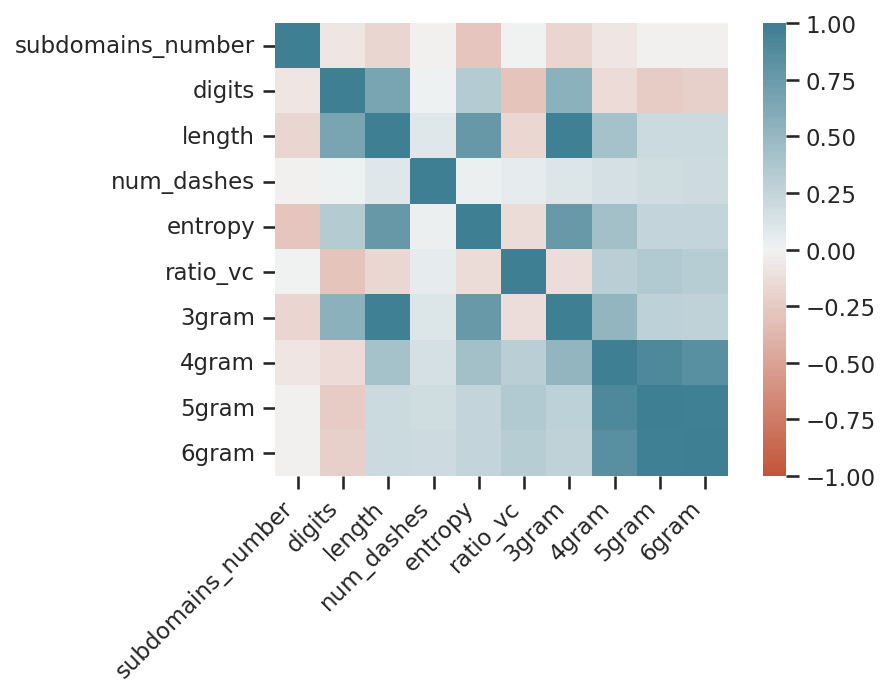

In [55]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

La correlación más evidente es entre los distintos n-gramas: Lógicamente, la relación entre 5gram y 6gram es muy fuerte, dado que un dominio con varios 6-gramas, tendrá, al menos, el mismo número de 5-gramas.

Existe también correlación, pero menos fuerte, entre la longitud y el número de dígitos y entre la entropía y la longitud y el número de 3-gramas.

# Reducción de la dimensionalidad con análisis de componentes principales (PCA)

Para poder visualizar la utilidad de los atributos calculados, realizaremos una reducción de la dimensionalidad utilizando PCA.

En primer lugar realizaremos PCA sobre las variables obtenidas a partir de las características léxicas y en segunda instancia realizaremos PCA sobre los n-grams.

En el caso de las variables léxicas este es el resultado obtenido:

In [56]:
var_df_std.head(1)

,subdomains_number,digits,length,num_dashes,entropy,ratio_vc,3gram,4gram,5gram,6gram
0,-0.255363,4.106603,3.101901,-0.159342,0.889879,-0.636341,2.856207,-0.131473,-0.827377,-0.707694


In [57]:
pca2 = PCA(n_components=2)
cols=['subdomains_number','digits','length','num_dashes','entropy','ratio_vc']
pca = pca2.fit_transform(var_df_std[cols])
pca_df = pd.DataFrame(data = pca, columns = ['PC1', 'PC2'])

Visualización de los datos

Text(0.5, 1.0, 'PCA a partir de features obtenidas de características léxicas')

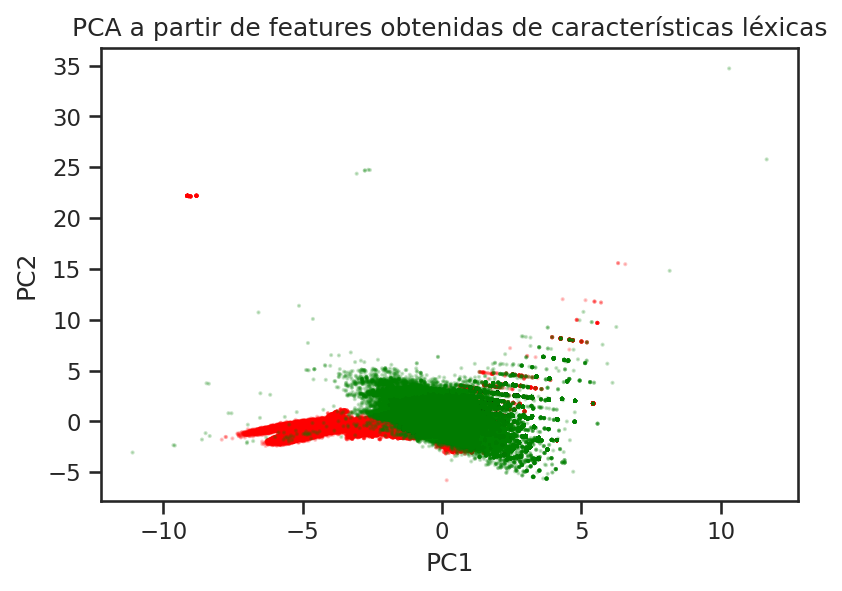

In [58]:
colors = {'malign':'red', 'benign':'green'}
plt.scatter(pca_df['PC1'].tolist(), 
            pca_df['PC2'].tolist(),
            alpha=0.2,
            s=1,
            c=full_df['category'].map(colors))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA a partir de features obtenidas de características léxicas")

In [59]:
print(pd.DataFrame(pca2.components_,columns=cols,index = ['PC-1','PC-2']))

      subdomains_number    digits    length  num_dashes   entropy  ratio_vc
PC-1           0.224453 -0.490989 -0.604500   -0.052959 -0.535500  0.231441
PC-2          -0.527105 -0.284781  0.054259    0.414429  0.217693  0.647282


Aunque visualmente sí se aprecia cierta separación de los datos, hay muchos de ellos que comparten valores similares de PC-1 y PC-2 para dominios benignos y malignos.

Las variables que más influencia tienen sobre los componentes principales son:
- Para `PC-1`: length, entropy y digits
- Para `PC-2`: ratio_v, subdomains_number y num_dashes



In [60]:
pca2 = PCA(n_components=2)
cols=['3gram','4gram','5gram','6gram']
pca = pca2.fit_transform(var_df_std[cols])
#pca = pca2.fit_transform(X)
pca_df = pd.DataFrame(data = pca, columns = ['PC1', 'PC2'])

Text(0.5, 1.0, 'PCA a partir de variables obtenidas de n-grams')

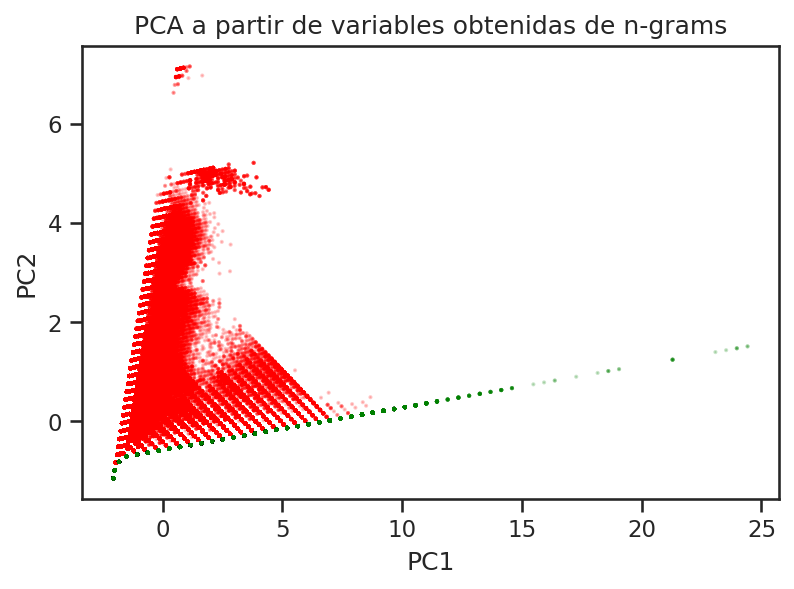

In [61]:
colors = {'malign':'red', 'benign':'green'}
plt.scatter(pca_df['PC1'].tolist(), 
            pca_df['PC2'].tolist(),
            alpha=0.2,
            s=1,
            c=full_df['category'].map(colors))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA a partir de variables obtenidas de n-grams")

In [62]:
print(pd.DataFrame(pca2.components_,columns=cols,index = ['PC-1','PC-2']))


         3gram     4gram     5gram     6gram
PC-1  0.296444  0.555144  0.553633  0.545368
PC-2  0.918239  0.057958 -0.273112 -0.280871


En el caso del PCA realizado a partir de los n-gramas la separación visual de clases es muy evidente. 

Las variables que más influencia tienen sobre los componentes principales son:
- Para `PC-1`: 5gram, 4gram y 6gram
- Para `PC-2`: 3gram. En menor medida 5gram y 6gram

Comparando ambos PCA es de esperar que los modelos de clasificación basados en n-gramas tengan mejor rendimiento que los basados en las variables derivadas de las características léxicas.

# Guardar CSV
Por último guardamos el CVS resultante para utilizarlo en las siguientes fases del proyecto

In [63]:
full_df.family = full_df.family.fillna('benign')
full_df.to_csv('/content/drive/MyDrive/TFM/data_processed/dga.csv')